# Inference with Muse

Muse performs "marginalization with unbiased score estimates", which computationally uses many MAP estimates to better approximate a mostly normal posterior for parameters of interest, given a large latent space which is not of interest.  This dovetails nicely with how most TVB simulations have to assume an enormous *nuisance* latent space due to stochastic integration.

Here we're testing the Jax interface with stochastic neural fields,

https://cosmicmar.com/muse_inference/advanced_examples.html#Jax


In [1]:
%pylab inline
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem
import nfjax

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
** shtns is not available


## Stochastic neural field

For this to work, we need a model structure that can take advantage of marginalization.

First the local coupling,

In [2]:
# local coupling setup
nlat, nlon = 32, 64
lc = nfjax.make_shtdiff(lmax=16, nlat=32, nlon=nlon)

# initial conditions
key = jax.random.PRNGKey(42)
x0 = jax.random.normal(key, (nlat, nlon))
x1 = lc(x0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Then the field simulation:

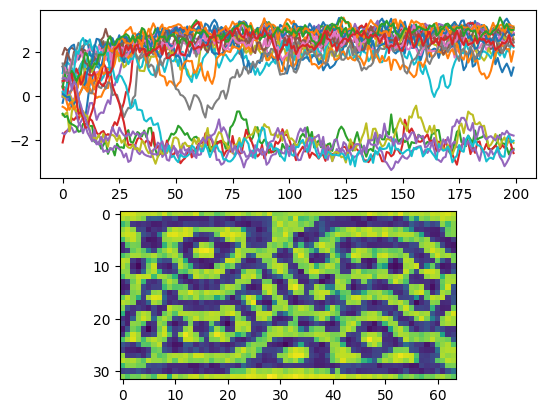

In [3]:
def dfun(x, k):
    return x - x**3/3 + k*lc(x)

dt = 0.1
sig = 1.0
step, loop = nfjax.make_sde(dt, dfun, sig)

key = jax.random.PRNGKey(42)
zt = jax.random.normal(key, (200, ) + x0.shape)

k = 5.0
xt = loop(x0, zt, k)

subplot(211); plot(xt[:,:5,:5].reshape((-1, 25)));
subplot(212); imshow(xt[-1])

## adapt problem for Muse interface

Anyway, we can adapt the problem to muse like this:

In [1]:
def make_muse(xt):
    
    nt = xt.shape[0]
    
    # TODO create reusable function to wrap this up
    class Model(JaxMuseProblem):

        def sample_x_z(self, key, θ):
            x0, log_k = θ
            z = jax.random.normal(key, (nt, ) + x0.shape)
            x = loop(x0, z, jnp.exp(log_k))
            return (x, z)

        def logLike(self, x, z, θ):
            return -jnp.sum((x - xt)**2)

        def logPrior(self, θ):
            x0, log_k = θ
            e = jnp.sum(x0**2) + (log_k - 1.6)**2
            return -e
    
    return Model()

and run the muse algorithm,

In [ ]:
prob = make_muse(xt)
key = jax.random.PRNGKey(0)
θ = x0, jnp.log(k)
(x, z) = prob.sample_x_z(key, θ)
prob.set_x(x)

θ0 = x0*1.1, jnp.log(k*1.1)
result = prob.solve(θ_start=θ0, rng=jax.random.PRNGKey(1), progress=True)

get_H:   0%|                                                                                                                  | 0/10 [00:00<?, ?it/s]

I seem to run out of memory here.. to be investigated.

## check solution 

The recovered hyperparameters match what we used to generate the data:

In [9]:
x0h, sigh, kh = result.θ
sig, jnp.exp(sigh), k, jnp.exp(kh)

(1.0, Array(1.0000006, dtype=float32), 5.0, Array(4.9530354, dtype=float32))

Then, modulo some scale factor (?), we recover the initial conditions:

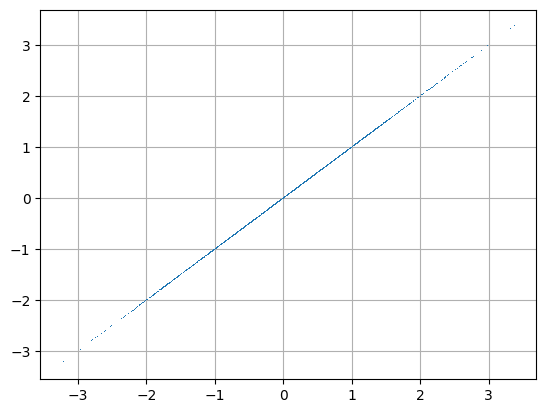

In [10]:
scl = (x0/x0h).mean()
plot(x0h.reshape(-1) * scl, x0.reshape(-1), ',')
grid(1)